In [10]:
import pandas as pd
import os
import shutil
import numpy as np

***

# Data preparation

In [11]:
data = pd.read_csv("./var_21.csv")

data.head()

,Unnamed: 0,ID,NAME,r ankle_X,r ankle_Y,r knee_X,r knee_Y,r hip_X,r hip_Y,l hip_X,...,r shoulder_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,Scale,Activity,Category
0,15780,15781,054881533.jpg,-1,-1,-1,-1,593,1071,882,...,519,894,457,1229,584,935,383,12.444503,"eating, sitting",self care
1,15781,15782,090616063.jpg,-1,-1,-1,-1,727,804,966,...,376,1031,364,1108,708,956,590,10.508739,"eating, sitting",self care
2,15782,15783,091272663.jpg,-1,-1,-1,-1,857,773,1093,...,339,1223,361,1350,566,1425,665,9.779757,"eating, sitting",self care
3,15783,15784,005476378.jpg,-1,-1,-1,-1,811,897,997,...,519,1071,525,1121,699,1093,860,8.988216,"eating, sitting",self care
4,15784,15785,007989940.jpg,-1,-1,-1,-1,-1,-1,-1,...,469,1115,497,1313,702,1164,693,8.784459,"eating, sitting",self care


In [12]:
KEYPOINTS_COLUMN_NAMES = ['r ankle_X', 'r ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X', 'r hip_Y', 'l hip_X', 'l hip_Y', 'l knee_X', 'l knee_Y', 'l ankle_X', 'l ankle_Y', 'pelvis_X', 'pelvis_Y', 'thorax_X', 'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y', 'r wrist_X', 'r wrist_Y', 'r elbow_X', 'r elbow_Y', 'r shoulder_X', 'r shoulder_Y', 'l shoulder_X', 'l shoulder_Y', 'l elbow_X', 'l elbow_Y', 'l wrist_X', 'l wrist_Y']

CONNECTIONS = {
    
}

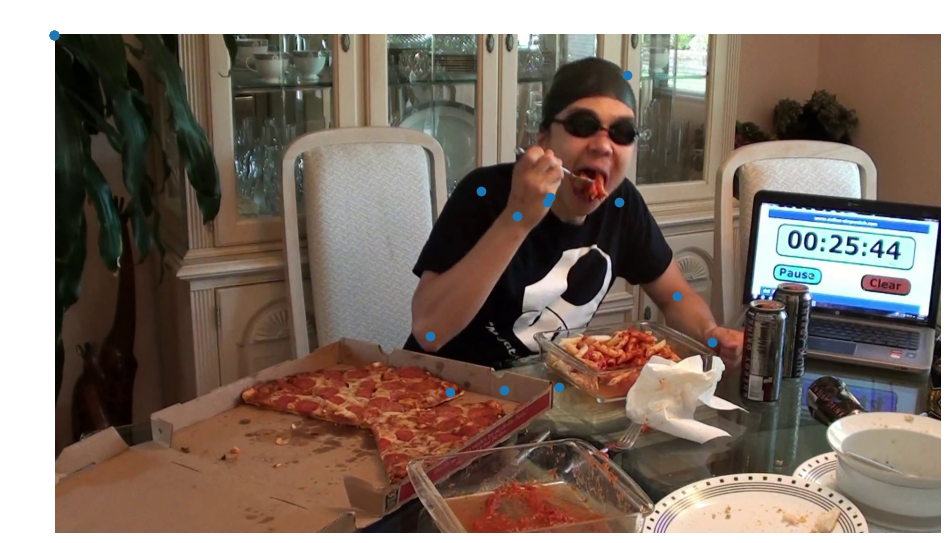

In [13]:
import matplotlib.pyplot as plt 
from PIL import Image

image_name = '091272663.jpg'
sample_img = Image.open(os.path.join('./dataset', image_name))
sample_keypoints = data[data['NAME'] == image_name]

Xs = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_X')]
Ys = [sample_keypoints[col].values[0] for col in KEYPOINTS_COLUMN_NAMES if col.endswith('_Y')]

plt.figure(figsize=(12, 7))

plt.imshow(sample_img)
plt.scatter(Xs, Ys)
plt.axis('off')

plt.show()

In [14]:
# train/validate разбиение

train_val_partition = 0.80
train_val_n = int(train_val_partition * len(data))

train_data = data.iloc[:train_val_n]
val_data = data.iloc[train_val_n:]

In [15]:
# Выбираем классы

idx_class = {i: cat for i, cat in enumerate(data['Category'].unique())}
class_idx = {cat: i for i, cat in idx_class.items()}

idx_class

{0: 'self care',
 1: 'miscellaneous',
 2: 'conditioning exercise',
 3: 'bicycling',
 4: '[]',
 5: 'religious activities',
 6: 'water activities',
 7: 'fishing and hunting',
 8: 'inactivity quiet/light',
 9: 'sports',
 10: 'home repair',
 11: 'winter activities',
 12: 'home activities',
 13: 'occupation',
 14: 'lawn and garden'}

In [16]:
def write_label_date(row, dir, image_name, bbox_offset=50):
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))
    width, height = img.width, img.height

    point_names = list(set([col.split('_')[0] for col in KEYPOINTS_COLUMN_NAMES]))
    Xs = [float(row[col+'_X']) for col in point_names if row[col+'_X'] > 0]
    Ys = [float(row[col+'_Y']) for col in point_names if row[col+'_Y'] > 0]
    min_x, max_x = max(min(Xs) - bbox_offset, 0), min(max(Xs) + bbox_offset, width)
    min_y, max_y = max(min(Ys) - bbox_offset, 0), min(max(Ys) + bbox_offset, height)
    
        
    with open(os.path.join(dir, image_name+'.txt'), 'w') as label_file:
        str_out = ""
        str_out += str(class_idx[row['Category']]) + " "
        str_out += str((min_x + (max_x - min_x) / 2) / width) + " "
        str_out += str((min_y + (max_y - min_y) / 2) / height) + " "
        str_out += str((max_x - min_x) / width) + " "
        str_out += str((max_y - min_y) / height) + " "

        for point in point_names:
            x = float(row[point+'_X'])
            y = float(row[point+'_Y'])

            if x < 0 or y < 0:
                str_out += "0.0 0.0 0 "
            else:
                str_out += str(x / width) + " " + str(y / height) + " 2 "
        
        label_file.write(str_out)

In [17]:
# Конвертируем датасет в формат yolov

yolov_ds_path = './yolov_dataset'


os.makedirs(yolov_ds_path, exist_ok=True)
for part in ['train', 'valid']:
    os.makedirs(os.path.join(yolov_ds_path, part, 'images'), exist_ok=True)
    os.makedirs(os.path.join(yolov_ds_path, part, 'labels'), exist_ok=True)

# train
for _, row in train_data.iterrows():
    image_name = row['NAME'].split('.')[0]
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))

    shutil.copy(
        f'./dataset/{image_name}.jpg',
        f'{yolov_ds_path}/train/images/{image_name}.jpg'
    )

    write_label_date(row, f'{yolov_ds_path}/train/labels/', image_name)

#validate
for _, row in val_data.iterrows():
    image_name = row['NAME'].split('.')[0]
    img = Image.open(os.path.join('./dataset', f'{image_name}.jpg'))

    shutil.copy(
        f'./dataset/{image_name}.jpg',
        f'{yolov_ds_path}/valid/images/{image_name}.jpg'
    )

    write_label_date(row, f'{yolov_ds_path}/valid/labels/', image_name)

In [18]:
print("Размер тренировочной выборки: ", len(train_data))
print("Размер валидационной выборки: ", len(val_data))
print()
print("Количество ключевых точек: ", int(len(KEYPOINTS_COLUMN_NAMES) / 2))
print("Количество состояний для предсказания: ", len(class_idx.keys()))

Размер тренировочной выборки:  631
Размер валидационной выборки:  158

Количество ключевых точек:  16
Количество состояний для предсказания:  15


***

## Модель

In [20]:
from ultralytics import YOLO

model = YOLO('yolov8s-pose.pt')

In [21]:
import torch
torch.cuda.is_available()

True

In [22]:
results = model.train(data='./yolov_dataset/data.yaml', epochs=200, imgsz=631, batch=8)

New https://pypi.org/project/ultralytics/8.2.27 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.26  Python-3.10.0rc1 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
engine\trainer: task=pose, mode=train, model=yolov8s-pose.pt, data=./yolov_dataset/data.yaml, epochs=200, time=None, patience=100, batch=8, imgsz=631, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train36, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=Non

wandb: Currently logged in as: bankavperm (nifpd). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


C:\Users\pdd\PycharmProjects\detect\venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


AMP: checks passed 
WARNING  imgsz=[631] must be multiple of max stride 32, updating to [640]


train: Scanning C:\Users\pdd\PycharmProjects\detect\yolov_dataset\train\labels.cache... 631 images, 0 backgrounds, 1 corrupt: 100%|██████████| 631/631 [00:00<?, ?it/s]Scanning C:\Users\pdd\PycharmProjects\detect\yolov_dataset\train\labels.cache... 631 images, 0 backgrounds, 1 corrupt: 100%|██████████| 631/631 [00:00<?, ?it/s]


train: WARNING  C:\Users\pdd\PycharmProjects\detect\yolov_dataset\train\images\027622731.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0208      1.0028]


val: Scanning C:\Users\pdd\PycharmProjects\detect\yolov_dataset\valid\labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]Scanning C:\Users\pdd\PycharmProjects\detect\yolov_dataset\valid\labels.cache... 158 images, 0 backgrounds, 0 corrupt: 100%|██████████| 158/158 [00:00<?, ?it/s]


Plotting labels to C:\Users\pdd\runs\pose\train36\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.0004, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\pdd\runs\pose\train36
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/79 [00:00<?, ?it/s]C:\Users\pdd\PycharmProjects\detect\venv\lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
      1/200      2.21G      1.398      10.42     0.6977      3.462       1.55         10        640: 100%|██████████| 79/79 [00:18<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95):   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\pdd\PycharmProjects\detect\venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudn

                   all        158        158      0.455      0.309       0.18      0.122          0          0          0          0


C:\Users\pdd\PycharmProjects\detect\venv\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.31G      1.179      9.319     0.6646      2.659      1.313         12        640: 100%|██████████| 79/79 [00:16<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


                   all        158        158      0.847      0.175      0.223      0.156          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.32G      1.119      8.618     0.6403      2.325      1.263         15        640: 100%|██████████| 79/79 [00:27<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


                   all        158        158      0.483      0.289      0.227      0.148          0          0          0          0

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/200       2.3G      1.143      8.247     0.6263      2.136      1.256         16        640: 100%|██████████| 79/79 [00:16<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


                   all        158        158      0.503      0.209      0.185      0.134      0.684    0.00538    0.00313   0.000313

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/200      2.29G      1.108      7.997     0.6095      1.996      1.227         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.14it/s]


                   all        158        158      0.486      0.252      0.187      0.128      0.341    0.00538    0.00294   0.000305

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/200      2.29G      1.093       7.71     0.6087      1.865       1.24         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.669      0.216      0.229      0.159      0.342     0.0134      0.005   0.000527

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/200       2.3G      1.069      7.503     0.5841      1.736      1.203         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


                   all        158        158      0.525      0.291      0.206      0.137      0.708     0.0215     0.0111    0.00114

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/200      2.28G       1.04       7.45     0.5911      1.663      1.185         12        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


                   all        158        158      0.433      0.295      0.181      0.126      0.345      0.026    0.00808   0.000808

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/200      2.32G      1.052      7.132     0.5783      1.574      1.188         19        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


                   all        158        158      0.436      0.268      0.207      0.139      0.353     0.0349     0.0181    0.00226

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/200      2.29G     0.9925      7.009     0.5548      1.488      1.161         11        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


                   all        158        158      0.559      0.256      0.272      0.186      0.377     0.0536     0.0272    0.00359

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/200       2.3G       1.01      6.938     0.5631      1.387      1.147         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.345      0.327      0.224      0.154       0.18     0.0269     0.0167      0.002

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/200      2.29G      1.009       6.84     0.5577      1.411      1.165         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


                   all        158        158      0.323      0.243      0.211      0.145       0.23     0.0609      0.045    0.00588

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/200      2.28G     0.9678      6.859     0.5508      1.293      1.134         17        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158      0.303      0.315      0.204      0.145       0.19     0.0341     0.0155      0.002

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/200      2.28G     0.9448      6.722     0.5398      1.287      1.131          9        640: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.325      0.248      0.216      0.155      0.377     0.0369     0.0255    0.00313

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/200      2.27G       0.99      6.642     0.5444      1.247      1.152         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.295      0.311      0.197      0.138      0.205     0.0802     0.0359    0.00595

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/200      2.28G     0.9388       6.65     0.5398      1.221      1.122         18        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.296       0.24      0.189      0.128      0.198     0.0368     0.0258    0.00352

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/200      2.29G     0.9146      6.552     0.5399      1.139      1.114          9        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.85it/s]


                   all        158        158      0.308      0.297      0.181      0.119      0.206     0.0674     0.0298    0.00412

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/200      2.28G     0.9318      6.493     0.5325      1.141      1.118         18        640: 100%|██████████| 79/79 [00:16<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


                   all        158        158      0.327      0.357      0.215      0.151       0.22     0.0881     0.0306    0.00422

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/200       2.3G     0.8921      6.505     0.5339      1.114      1.092         21        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.352       0.37      0.279      0.196      0.387     0.0538     0.0422    0.00553

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/200      2.31G     0.8762      6.543     0.5169      1.046      1.073          9        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.318      0.319      0.226      0.159      0.195     0.0732       0.03    0.00407

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/200      2.29G     0.9202      6.339     0.5316      1.076      1.118         17        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.76it/s]


                   all        158        158      0.311      0.304      0.212       0.15      0.204     0.0521     0.0273    0.00406

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/200      2.29G     0.9063      6.387     0.5211      1.069      1.108         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.13it/s]


                   all        158        158      0.325       0.32      0.199      0.128      0.198     0.0567     0.0352    0.00475

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/200      2.28G     0.8729      6.228     0.5057      1.019      1.079         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


                   all        158        158      0.177      0.344      0.251      0.174      0.081        0.1     0.0671     0.0106

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/200      2.28G     0.9096      6.363     0.5115       1.02      1.106         18        640: 100%|██████████| 79/79 [00:16<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.141      0.335      0.227       0.16     0.0561      0.104     0.0572    0.00828

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/200       2.3G     0.8839      6.166     0.5175      1.007      1.095         14        640: 100%|██████████| 79/79 [00:15<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


                   all        158        158      0.163      0.276      0.195      0.136     0.0658     0.0979     0.0528    0.00804

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/200       2.3G     0.8591      6.204     0.5175     0.9671      1.082         21        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.144      0.372       0.22       0.15      0.212     0.0813      0.033     0.0049

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/200       2.3G     0.8581      6.084     0.5183     0.9685      1.088         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.348      0.303      0.211      0.152      0.251      0.117     0.0635     0.0118

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/200       2.3G     0.8797      6.088     0.5112     0.9597      1.087         17        640: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


                   all        158        158      0.368      0.268      0.231      0.172     0.0281      0.256     0.0542    0.00833

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/200      2.29G     0.8688      6.218     0.5085     0.9515      1.093         17        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


                   all        158        158      0.124      0.284      0.166       0.12      0.238     0.0469     0.0376    0.00595

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/200      2.29G     0.8256      6.002     0.4903     0.9074      1.065         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.433      0.323      0.253      0.176       0.32      0.111     0.0608    0.00816

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/200      2.28G     0.7988      5.984     0.4809     0.8856      1.056         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


                   all        158        158      0.223       0.29      0.218      0.146     0.0959     0.0822     0.0456     0.0068

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/200      2.28G     0.8352      5.956      0.486     0.8511      1.062         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


                   all        158        158      0.209      0.306      0.218      0.158     0.0804      0.082     0.0443    0.00775

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/200      2.29G     0.8534      5.994     0.4885     0.8944      1.087         10        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


                   all        158        158      0.182      0.325      0.216      0.155     0.0843      0.107      0.054    0.00867

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/200      2.28G     0.8058       5.95     0.4789     0.8627      1.057         14        640: 100%|██████████| 79/79 [00:24<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.03it/s]


                   all        158        158      0.175      0.328      0.248      0.179     0.0661      0.117     0.0599    0.00951

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/200      2.29G     0.8021        5.8     0.4797       0.83      1.045         13        640: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


                   all        158        158      0.147      0.289      0.211      0.154     0.0721      0.113     0.0464     0.0084

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/200      2.28G     0.7909      5.786     0.4748      0.816      1.051         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


                   all        158        158      0.249      0.307      0.229      0.161     0.0388     0.0695     0.0368    0.00609

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/200      2.28G     0.7683      5.844     0.4864     0.8066      1.044         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


                   all        158        158      0.299      0.233      0.174      0.127      0.376     0.0309      0.023    0.00411

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/200      2.28G     0.7458       5.71     0.4585     0.7915      1.018         13        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


                   all        158        158      0.336      0.232      0.201      0.152      0.208      0.051      0.038    0.00485

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/200      2.28G     0.7457      5.755     0.4705     0.7657      1.033         19        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


                   all        158        158      0.384      0.252      0.213      0.155      0.451     0.0507     0.0467    0.00852

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/200      2.28G     0.7784      5.624     0.4719     0.7989      1.037         16        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


                   all        158        158      0.132      0.278      0.191      0.143     0.0261      0.194     0.0447    0.00669

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/200       2.3G     0.7716      5.748       0.46     0.7906      1.035         10        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.156      0.298      0.174      0.124     0.0392     0.0636     0.0331    0.00503

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/200      2.29G     0.7664      5.673     0.4457     0.7747      1.036         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


                   all        158        158      0.164      0.271      0.195      0.147     0.0477      0.067      0.039    0.00691

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/200      2.29G     0.7751      5.767     0.4533     0.7785      1.043         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.398      0.383      0.261      0.197       0.28      0.105     0.0429    0.00709

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/200      2.29G     0.7642      5.646     0.4597        0.8      1.048         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.217      0.295      0.218      0.162     0.0917      0.102     0.0593     0.0116

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/200      2.31G     0.7442      5.611     0.4526     0.7638      1.024         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.391      0.299      0.223      0.158     0.0347      0.368     0.0676     0.0128

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/200      2.29G     0.7396      5.614     0.4302     0.7237      1.024         16        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.201      0.288      0.216      0.156     0.0531     0.0817     0.0498    0.00947

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/200      2.29G     0.7278      5.596     0.4324     0.7187      1.013         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


                   all        158        158       0.24      0.287      0.207      0.148     0.0393     0.0646     0.0293    0.00487

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/200      2.27G      0.739      5.527       0.45     0.7287      1.024         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


                   all        158        158      0.146      0.283      0.225      0.161      0.234     0.0643     0.0365    0.00646

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/200       2.3G     0.7126      5.355     0.4173     0.6851      1.014         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.254      0.345      0.263      0.195     0.0995      0.126     0.0481    0.00852

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/200      2.29G     0.7134      5.367     0.4243     0.6979      1.007          9        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


                   all        158        158      0.387      0.217      0.229      0.167      0.264     0.0683     0.0583       0.01

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/200       2.3G     0.7352       5.47     0.4326       0.71       1.03         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


                   all        158        158      0.353      0.315      0.227      0.163      0.216     0.0808     0.0408    0.00597

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/200       2.3G     0.7236      5.467     0.4106     0.7063      1.006         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.311      0.252      0.241      0.164      0.225     0.0537     0.0425    0.00673

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/200      2.31G     0.7114        5.4     0.4085     0.6785      1.019         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


                   all        158        158      0.145      0.278      0.206      0.149      0.305     0.0686     0.0574     0.0101

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/200       2.3G     0.7012      5.409     0.4076     0.6796      1.003         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.148      0.263       0.22       0.16      0.243      0.068     0.0402    0.00613

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/200      2.28G     0.6882      5.356     0.4102     0.6629     0.9915         11        640: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.188      0.292      0.245      0.174      0.252     0.0694     0.0486    0.00809

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/200      2.28G     0.6811      5.304     0.3956     0.6671     0.9995         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


                   all        158        158      0.336      0.274      0.238      0.162      0.253      0.121     0.0777      0.013

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/200       2.3G     0.7008      5.434     0.3954     0.6854       1.01         10        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


                   all        158        158      0.183       0.28      0.192      0.137       0.11      0.103     0.0545    0.00968

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/200      2.29G     0.6628      5.193     0.3979     0.6316      1.001         16        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.431      0.302      0.248      0.182      0.241     0.0947     0.0667     0.0116

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/200      2.29G      0.677      5.149     0.3961     0.6584      1.005         16        640: 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.208      0.227      0.234      0.169     0.0737     0.0787     0.0502    0.00778

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/200       2.3G     0.6677      5.122     0.3822     0.6234     0.9794         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


                   all        158        158       0.19      0.269       0.22      0.165      0.258     0.0822     0.0574     0.0105

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/200      2.28G     0.6772      5.165     0.3939     0.6357     0.9958         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


                   all        158        158       0.22      0.303        0.2      0.144     0.0909     0.0947     0.0527    0.00865

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/200       2.3G     0.6827      5.195     0.3971     0.6408      1.009         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


                   all        158        158      0.194      0.316      0.223      0.157      0.132      0.117     0.0754     0.0139

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/200      2.29G     0.6741       5.18     0.3912     0.6191     0.9823          9        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


                   all        158        158      0.333      0.272       0.23      0.167       0.26      0.119     0.0828     0.0179

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/200      2.29G     0.6661      5.125     0.3892     0.6308     0.9863         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


                   all        158        158     0.0968      0.644      0.192       0.14     0.0507      0.205     0.0636     0.0124

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/200       2.3G     0.6862      5.124     0.3755     0.6231          1         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.163      0.298      0.265      0.189     0.0703      0.113     0.0576     0.0109

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/200      2.29G     0.6457      5.011     0.3739     0.6233     0.9779         11        640: 100%|██████████| 79/79 [00:15<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


                   all        158        158      0.175      0.254      0.217      0.162     0.0993      0.113     0.0714     0.0128

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/200      2.29G     0.6585      5.044     0.3844     0.6088      0.983         12        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


                   all        158        158      0.197      0.261      0.193      0.141     0.0724     0.0921     0.0489    0.00928

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/200      2.29G     0.6555      5.147     0.3814     0.6035     0.9822         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.266      0.233       0.19      0.141      0.138     0.0687     0.0506    0.00914

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/200      2.28G     0.6397      5.056     0.3673      0.603     0.9654         18        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.325      0.256      0.179      0.133     0.0509     0.0762     0.0362     0.0073

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/200      2.28G     0.6628      5.007     0.3701     0.6126     0.9845         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.506      0.235      0.226      0.172     0.0586      0.117     0.0768     0.0145

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/200      2.27G     0.6513      5.071     0.3754     0.5957     0.9926          9        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


                   all        158        158      0.354      0.244      0.213      0.154       0.44     0.0684     0.0607     0.0105

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/200      2.29G     0.6346      4.943     0.3721     0.5832     0.9714         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.327      0.287      0.214      0.162       0.24       0.13     0.0849     0.0168

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/200       2.3G     0.6334      5.036     0.3641     0.5805     0.9646         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


                   all        158        158      0.532      0.181      0.198      0.149      0.399      0.106     0.0722     0.0148

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/200       2.3G     0.6514      4.869     0.3698     0.6006     0.9867         16        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


                   all        158        158      0.143      0.275      0.223      0.168     0.0584       0.11     0.0748     0.0132

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/200      2.31G     0.6266      4.853     0.3705     0.5775     0.9693         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


                   all        158        158      0.572      0.215       0.23      0.172     0.0321       0.16     0.0406    0.00904

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/200       2.3G      0.639      4.884     0.3679     0.5798     0.9716         12        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


                   all        158        158      0.184      0.273      0.223      0.165     0.0715     0.0901     0.0466      0.009

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/200      2.28G     0.6244      4.837      0.355     0.5731     0.9665         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        158        158      0.357      0.272       0.23      0.168     0.0815      0.136     0.0643     0.0139

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/200      2.27G     0.6331      4.837     0.3547     0.5869      0.972         18        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


                   all        158        158      0.311      0.245      0.218      0.161      0.446     0.0642     0.0502    0.00948

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/200      2.28G     0.6195      4.821     0.3693     0.5755     0.9701         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.318      0.232      0.177      0.132      0.239      0.112     0.0703     0.0132

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/200      2.28G      0.612      4.773     0.3452     0.5527     0.9658         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


                   all        158        158      0.348      0.251        0.2      0.153      0.278     0.0991     0.0525     0.0104

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/200       2.3G     0.6211      4.746      0.359     0.5612     0.9697         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


                   all        158        158      0.352      0.265      0.202      0.148      0.253     0.0881     0.0403    0.00744

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/200      2.27G     0.6026      4.718     0.3531     0.5384      0.965         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


                   all        158        158      0.304      0.273      0.205       0.15      0.206     0.0751     0.0362    0.00728

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/200       2.3G     0.6108      4.637     0.3489       0.55     0.9722         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


                   all        158        158      0.165      0.273      0.212      0.159      0.257     0.0643     0.0409    0.00836

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/200      2.28G     0.5865       4.71     0.3504     0.5319     0.9498         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


                   all        158        158       0.34      0.232       0.21      0.155      0.433      0.087     0.0736     0.0138

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/200      2.28G     0.6168      4.708     0.3613     0.5327     0.9718         19        640: 100%|██████████| 79/79 [00:16<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


                   all        158        158      0.508      0.212      0.199      0.144     0.0467      0.199     0.0538     0.0101

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/200      2.28G     0.6069      4.626     0.3431     0.5336     0.9642         16        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.27it/s]


                   all        158        158       0.11      0.578      0.205      0.151     0.0477      0.237     0.0614     0.0138

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/200      2.27G     0.6112      4.616     0.3501     0.5534     0.9647         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.523      0.216      0.207      0.152     0.0464      0.184     0.0463       0.01

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/200      2.28G     0.6038      4.606     0.3441     0.5574     0.9645         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.548      0.216      0.209      0.157      0.422     0.0843     0.0531    0.00943

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/200      2.29G     0.5908      4.598     0.3434     0.5391     0.9675          9        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.22it/s]


                   all        158        158      0.375      0.298      0.224      0.176      0.278      0.126     0.0718     0.0137

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/200      2.29G     0.5937      4.572     0.3364     0.5292     0.9691         11        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


                   all        158        158      0.354      0.292      0.247      0.188      0.255     0.0929     0.0639     0.0124

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/200      2.28G     0.5753      4.681     0.3511     0.5024     0.9526         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


                   all        158        158      0.413      0.211      0.218      0.161      0.226     0.0948       0.07     0.0161

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/200      2.28G     0.5968      4.542     0.3468     0.5274      0.959         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158      0.422      0.225      0.216      0.164      0.306      0.095     0.0643     0.0144

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/200      2.28G     0.6002      4.514     0.3451     0.5194     0.9553         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.588       0.23      0.225      0.166      0.488     0.0955     0.0668     0.0156

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/200      2.28G     0.5674      4.386     0.3282     0.4953     0.9382         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.373      0.233      0.211      0.158      0.271     0.0997     0.0808     0.0178

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/200      2.28G      0.567      4.474     0.3355     0.5017     0.9446         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.04it/s]


                   all        158        158      0.173      0.254      0.204      0.156      0.075     0.0894     0.0497     0.0114

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/200      2.28G       0.59      4.461     0.3462     0.5396     0.9605         12        640: 100%|██████████| 79/79 [00:16<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


                   all        158        158      0.304      0.243      0.182      0.139      0.226     0.0765     0.0477     0.0102

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/200      2.29G     0.5683      4.447     0.3417     0.5114     0.9578         11        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.553      0.242      0.189      0.145      0.434      0.113     0.0733     0.0173

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/200      2.28G     0.5644      4.512     0.3413     0.5099     0.9488         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


                   all        158        158      0.223      0.263      0.197      0.152      0.283      0.104      0.054     0.0123

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/200      2.29G     0.5897       4.48     0.3313     0.5286      0.955         11        640: 100%|██████████| 79/79 [00:16<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


                   all        158        158      0.385      0.257      0.201      0.153       0.27     0.0617     0.0435    0.00837

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/200      2.29G     0.5736      4.405     0.3248     0.5006     0.9478         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


                   all        158        158      0.146      0.253        0.2      0.151     0.0515      0.163     0.0723     0.0133

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/200      2.27G     0.5651      4.378      0.335      0.495     0.9451         19        640: 100%|██████████| 79/79 [00:16<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


                   all        158        158      0.176      0.258      0.191      0.145     0.0655     0.0898     0.0468    0.00891

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/200      2.29G     0.5874       4.48      0.335     0.4909     0.9546         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.352      0.279      0.224      0.167      0.269      0.107     0.0678     0.0149

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/200      2.29G     0.5487      4.426     0.3415     0.4781     0.9398         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.02it/s]


                   all        158        158      0.339      0.255      0.196      0.151      0.585     0.0656     0.0451     0.0105

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/200      2.28G     0.5537      4.306     0.3394     0.4862      0.952         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


                   all        158        158      0.406      0.262      0.206      0.158      0.241      0.085     0.0534     0.0131

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/200       2.3G     0.5507      4.321     0.3428      0.498     0.9454         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.351      0.274      0.201      0.154       0.24       0.12     0.0622     0.0133

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/200      2.29G     0.5596      4.353     0.3262     0.4824      0.944         16        640: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


                   all        158        158      0.349      0.264      0.184      0.136      0.232     0.0974     0.0545     0.0115

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/200      2.29G     0.5251       4.36       0.33     0.4547     0.9219         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.346      0.235      0.209      0.153     0.0495      0.209      0.062     0.0132

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/200      2.29G     0.5448      4.386      0.328     0.4859      0.942         18        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.178      0.252        0.2      0.153     0.0769     0.0881     0.0494     0.0106

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/200       2.3G      0.539      4.252     0.3231      0.471     0.9373         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


                   all        158        158      0.212      0.275      0.211      0.159      0.106     0.0982     0.0593     0.0137

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/200       2.3G     0.5413      4.371     0.3365     0.4753     0.9319         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


                   all        158        158      0.463      0.257      0.214      0.166      0.291     0.0969     0.0511     0.0111

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/200      2.28G     0.5548      4.311      0.341     0.4901     0.9398         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


                   all        158        158        0.5      0.252      0.221      0.174      0.349     0.0817      0.058     0.0116

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/200      2.28G     0.5449      4.159     0.3234     0.4714     0.9418         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.26it/s]


                   all        158        158      0.353      0.219      0.195      0.149      0.273      0.101     0.0699      0.016

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/200      2.29G     0.5614      4.202     0.3244       0.49     0.9483         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.344       0.27      0.196      0.155      0.247      0.113     0.0565     0.0121

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/200      2.29G     0.5413      4.195     0.3191     0.4676     0.9333         16        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158      0.371      0.274      0.207      0.167     0.0803      0.113     0.0477     0.0122

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/200       2.3G     0.5322      4.024     0.3261     0.4542     0.9427         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


                   all        158        158      0.216      0.273      0.203      0.159      0.106      0.108      0.074      0.019

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/200      2.29G     0.5293      4.165     0.3239     0.4526      0.929         12        640: 100%|██████████| 79/79 [00:16<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158      0.235       0.25      0.203      0.152      0.151     0.0771     0.0531     0.0128

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/200      2.28G     0.5011      4.085     0.3365     0.4335     0.9244         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.205      0.291      0.212      0.158      0.108      0.112     0.0619     0.0147

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/200      2.28G     0.5316      4.195     0.3157     0.4478     0.9387         20        640: 100%|██████████| 79/79 [00:16<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.87it/s]


                   all        158        158      0.347      0.267      0.208      0.157      0.236     0.0964     0.0472     0.0121

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/200      2.28G     0.5033      4.116     0.3293     0.4569     0.9251         10        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158      0.231      0.285      0.209      0.166      0.103     0.0961     0.0468     0.0109

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/200      2.27G     0.5252      4.176      0.325     0.4571     0.9465         11        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.297       0.26      0.217      0.176      0.185     0.0859     0.0563     0.0126

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    121/200      2.28G     0.5133      4.146       0.32      0.437     0.9282         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


                   all        158        158      0.231      0.273      0.222      0.176     0.0821     0.0815     0.0533     0.0142

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    122/200      2.29G     0.5356      4.038     0.3291     0.4495      0.938         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.00it/s]


                   all        158        158      0.191      0.274      0.208      0.164      0.294     0.0967     0.0666     0.0176

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    123/200       2.3G     0.5037      4.078     0.3347     0.4434     0.9297         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158       0.25      0.308      0.214      0.171      0.148      0.127     0.0675     0.0196

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    124/200      2.28G     0.5158      4.074      0.325     0.4342     0.9348         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.12it/s]


                   all        158        158      0.179      0.262      0.201      0.157       0.07     0.0749     0.0424    0.00943

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    125/200      2.28G     0.4951      4.133     0.3297     0.4258     0.9183         16        640: 100%|██████████| 79/79 [00:15<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158      0.379      0.263      0.232      0.182      0.248     0.0923      0.055     0.0131

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    126/200      2.28G     0.5222      4.141     0.3333     0.4449     0.9388         10        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


                   all        158        158       0.39      0.239      0.231      0.178      0.251     0.0762      0.044     0.0116

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    127/200      2.28G     0.4993      4.053     0.3282     0.4383     0.9371         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


                   all        158        158      0.399      0.272      0.241      0.186      0.267     0.0954     0.0592     0.0163

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    128/200      2.27G     0.5018       3.97     0.3261      0.428     0.9181         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


                   all        158        158      0.442      0.245      0.224      0.172       0.24     0.0981     0.0668     0.0184

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    129/200      2.29G     0.5227       3.98     0.3253     0.4488     0.9402         15        640: 100%|██████████| 79/79 [00:16<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.19it/s]


                   all        158        158      0.372      0.285      0.227      0.176      0.291      0.139     0.0756     0.0187

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    130/200      2.28G     0.5055      4.014     0.3196     0.4466     0.9266         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


                   all        158        158      0.405      0.274      0.221      0.174      0.295      0.119     0.0727     0.0155

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    131/200       2.3G     0.4973      3.974      0.311     0.4352     0.9155         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


                   all        158        158       0.46      0.247       0.22      0.167      0.324     0.0896     0.0512     0.0131

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    132/200      2.31G     0.4945      4.008     0.3248     0.4334     0.9378         13        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


                   all        158        158      0.401      0.292      0.238      0.178      0.271      0.117     0.0716     0.0175

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    133/200      2.28G     0.4844      3.961     0.3215      0.415      0.924          9        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.184      0.248      0.208      0.163     0.0829     0.0996     0.0767     0.0196

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    134/200      2.27G     0.4927        3.9     0.3055     0.4252     0.9216         11        640: 100%|██████████| 79/79 [00:16<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


                   all        158        158      0.357      0.265       0.21      0.164      0.272     0.0902     0.0616     0.0133

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    135/200      2.28G     0.5085      4.034     0.3198     0.4365      0.927         12        640: 100%|██████████| 79/79 [00:16<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.08it/s]


                   all        158        158      0.349       0.26      0.204       0.16      0.268      0.108     0.0715     0.0187

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    136/200      2.29G     0.4882      3.922     0.3224     0.4144     0.9193         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.10it/s]


                   all        158        158       0.55      0.212      0.214       0.17      0.231     0.0684     0.0443     0.0105

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    137/200       2.3G     0.4917      3.932      0.316     0.4288     0.9173         13        640: 100%|██████████| 79/79 [00:16<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


                   all        158        158      0.346      0.249      0.203      0.158      0.232     0.0965     0.0729     0.0155

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    138/200      2.29G     0.5042      3.884     0.3133     0.4292     0.9265         10        640: 100%|██████████| 79/79 [00:15<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158      0.577      0.241      0.197      0.148      0.415     0.0884     0.0684     0.0163

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    139/200       2.3G     0.4889      3.832     0.3196     0.4294     0.9244         14        640: 100%|██████████| 79/79 [00:16<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  5.94it/s]


                   all        158        158      0.271      0.268      0.212       0.16     0.0768     0.0928     0.0612      0.015

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    140/200      2.28G     0.4876      3.862     0.3309      0.408     0.9267         17        640: 100%|██████████| 79/79 [00:16<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.38it/s]


                   all        158        158      0.409      0.235      0.198      0.151     0.0724     0.0781     0.0712     0.0153

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    141/200       2.3G     0.4829      3.881     0.3146     0.4097     0.9231         10        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


                   all        158        158      0.457      0.246      0.195      0.153      0.246     0.0755     0.0555     0.0147

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    142/200      2.29G     0.5047      3.853     0.3186     0.4209     0.9291         15        640: 100%|██████████| 79/79 [00:15<00:00,  4.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


                   all        158        158        0.5      0.244      0.188      0.146      0.293     0.0801     0.0546      0.016

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    143/200      2.28G     0.4775      3.912     0.3202     0.4021     0.9235         14        640: 100%|██████████| 79/79 [00:15<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


                   all        158        158      0.432      0.261      0.198      0.156      0.256     0.0914     0.0507     0.0134
EarlyStopping: Training stopped early as no improvement observed in last 100 epochs. Best results observed at epoch 43, best model saved as best.pt.
To update EarlyStopping(patience=100) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

143 epochs completed in 0.806 hours.
Optimizer stripped from C:\Users\pdd\runs\pose\train36\weights\last.pt, 23.5MB
Optimizer stripped from C:\Users\pdd\runs\pose\train36\weights\best.pt, 23.5MB

Validating C:\Users\pdd\runs\pose\train36\weights\best.pt...
Ultralytics YOLOv8.2.26  Python-3.10.0rc1 torch-2.3.0+cu118 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11264MiB)
YOLOv8s-pose summary (fused): 187 layers, 11590335 parameters, 0 gradients, 30.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.79it/s]


                   all        158        158        0.4      0.384      0.261      0.198       0.28      0.105     0.0429    0.00709
 conditioning exercise         25         25      0.327          1      0.521      0.421     0.0252       0.08     0.0161    0.00161
   fishing and hunting          1          1          1          0          0          0          1          0          0          0
       home activities         23         23      0.126      0.314     0.0989      0.073     0.0165     0.0435     0.0101    0.00148
         miscellaneous         62         62      0.429      0.629      0.458      0.347      0.213      0.323      0.136     0.0237
         music playing         21         21      0.328     0.0934      0.284      0.195      0.397      0.143     0.0863     0.0133
               running         26         26      0.192      0.269      0.207      0.149     0.0257     0.0385     0.0088    0.00241
Speed: 0.1ms preprocess, 3.3ms inference, 0.0ms loss, 1.2ms postproce

lr/pg0,▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▅███▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▅▁▁▄▂▄▃▅█▇▆▂▅▅▇▅█▅▅▅▄▅▃▄▄▇▄▃▅▁▃▂▃▅▃▆▅▄▃▂
metrics/mAP50(P),▁▁▂▅▃▄▄▄▆▆▄▅▆▄▅▄▆▇▇▇█▅▅▇▅▆█▅▇▅▅▇▅▆▄▅▇▆▇▆
metrics/mAP50-95(B),▄▂▁▃▁▄▁▄▇▇▅▃▅▅▅▅▇▄▅▆▅▅▄▄▄█▅▄▆▂▄▄▄▇▅▇▆▅▃▃
metrics/mAP50-95(P),▁▁▁▃▂▃▃▃▄▅▃▄▆▄▄▃▆▆▆▇█▅▅▆▅▆█▆▇▆▅▇▆▆▅▆▇▆▇▇
metrics/precision(B),█▅▄▃▃▃▃▁▄▁▂▁▂▁▃▁▄▂▁▅▃▂▃▃▅▃▃▂▃▃▁▃▂▃▁▄▄▃▅▅
metrics/precision(P),▁█▅▃▃▃▃▃▄▂▁▁▂▃▃▃▃▂▂▂▃▂▄▅▅▄▄▄▄▃▂▄▃▃▂▄▄▄▅▄
metrics/recall(B),▁▂▅▃▃▇▆█▆▆▆▅▅▅▄▄▅▆▄▃▅▄▄▃▂▅▃▄▅▄▄▃▄▄▄▃▄▄▃▃
metrics/recall(P),▁▁▂▃▂▄▃▄▅▅▄█▅▃▃▃▄▅▅▅▆▄▅▄▄▄▅▅▅▅▄▅▄▄▄▄▅▄▄▄


image 1/1 C:\Users\pdd\PycharmProjects\detect\lll.jpg: 384x640 1 conditioning exercise, 115.5ms
Speed: 6.0ms preprocess, 115.5ms inference, 4.0ms postprocess per image at shape (1, 3, 384, 640)


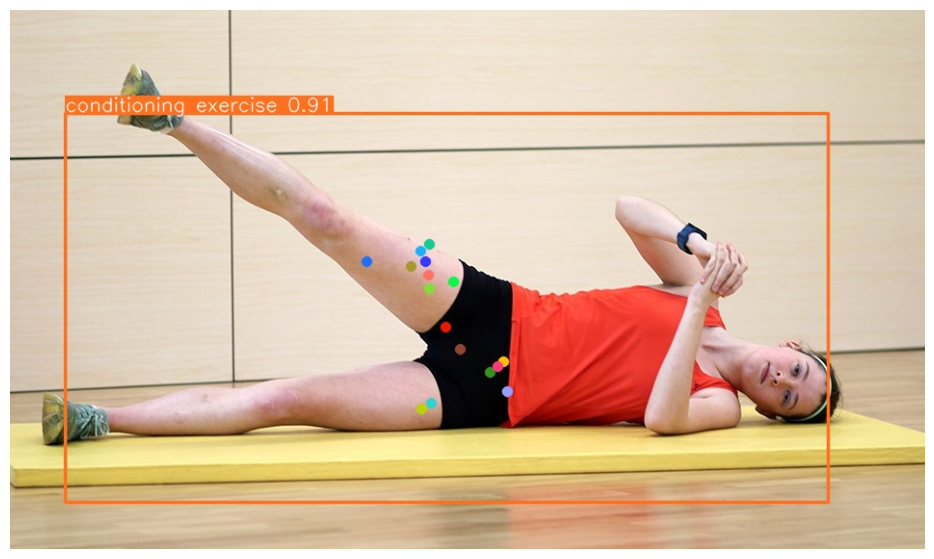

In [33]:
results = model("C:/Users/pdd/PycharmProjects/detect/lll.jpg")

for result in results:
    result.save("result.jpg")

plt.figure(figsize=(12, 7))

plt.imshow(Image.open("result.jpg"))
plt.axis('off')

plt.show()